# 네이버 영화리뷰 감정 분석
네이버 영화의 댓글을 모아 구성된 파일을 활용한다.  
https://github.com/e9t/nsmc

## 데이터 준비와 확인

In [1]:
import pandas as pd
import tensorflow as tf
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter


train_data = pd.read_table('/users/ho/desktop/data/wordvectors/ratings_train.txt')
test_data = pd.read_table('/users/ho/desktop/data/wordvectors/ratings_test.txt')

train_data.head()

Init Plugin
Init Graph Optimizer
Init Kernel


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## Data Loder 구성
nsmc 데이터셋은 ibdb처럼 친절하게 word_to_index 같은 메소드를 제공하지 않는다.  
그래서 Data Loder를 만들어야 한다.

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # NaN 결측치 제거
    train_data = train_data.dropna(how = 'any')
    test_data = test_data.dropna(how = 'any')
    
    # 한국어 토크나이저로 토큰화
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) #한국어 토크나이저로 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어(Stopwords) 제거
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) #한국어 토크나이저로 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어(Stopwords) 제거
        X_test.append(temp_X)
    
    
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    
    # 사전 word_to_index 구성
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    # X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델구성을 위한 데이터 분석 및 가공

### 데이터셋 내 문장 길이 분포

In [5]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455


### 적절한 최대 문장 길이 지정

In [6]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [7]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index[''],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index[''],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


## 모델구성

In [8]:
# RNN model 설계
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


2021-08-10 14:05:41.097449: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-10 14:05:41.098043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Validation set 구성

In [9]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## Model 훈련

In [10]:
tf.compat.v1.ConfigProto()
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


epochs=40  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: METAL, pci bus id: <undefined>



2021-08-10 14:05:41.230095: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-10 14:05:41.230113: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/40


2021-08-10 14:05:41.333611: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-10 14:05:41.336702: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-08-10 14:05:41.800830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-10 14:05:41.926851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-10 14:05:42.139271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


266/266 [==============================] - ETA: 0s - loss: 0.5196 - accuracy: 0.7413

2021-08-10 14:06:00.113387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-10 14:06:00.154423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


266/266 [==============================] - 20s 68ms/step - loss: 0.5196 - accuracy: 0.7413 - val_loss: 0.3667 - val_accuracy: 0.8434
Epoch 2/40
266/266 [==============================] - 16s 59ms/step - loss: 0.3489 - accuracy: 0.8529 - val_loss: 0.3499 - val_accuracy: 0.8477
Epoch 3/40
266/266 [==============================] - 15s 57ms/step - loss: 0.3304 - accuracy: 0.8617 - val_loss: 0.3449 - val_accuracy: 0.8511
Epoch 4/40
266/266 [==============================] - 15s 58ms/step - loss: 0.3220 - accuracy: 0.8669 - val_loss: 0.3493 - val_accuracy: 0.8455
Epoch 5/40
266/266 [==============================] - 15s 58ms/step - loss: 0.3169 - accuracy: 0.8694 - val_loss: 0.3531 - val_accuracy: 0.8447
Epoch 6/40
266/266 [==============================] - 15s 58ms/step - loss: 0.3140 - accuracy: 0.8703 - val_loss: 0.3539 - val_accuracy: 0.8435
Epoch 7/40
266/266 [==============================] - 16s 60ms/step - loss: 0.3116 - accuracy: 0.8716 - val_loss: 0.3600 - val_accuracy: 0.8401
Epo

In [11]:
# 테스트셋으로 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 24s - loss: 0.4729 - accuracy: 0.8160
[0.47285085916519165, 0.8159977197647095]


## Loss, Accuracy 그래프 시각화

In [12]:
# history 데이터를 그래프로 그려 보면, 수행했던 딥러닝 학습이 잘 진행 됐는지, 오버피팅이나 언더피팅하지 않았는지 확인 가능
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


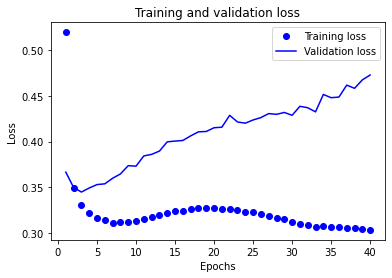

In [13]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
# 몇 epoch 까지의 트레이닝이 적절한지 최적점 추정 가능

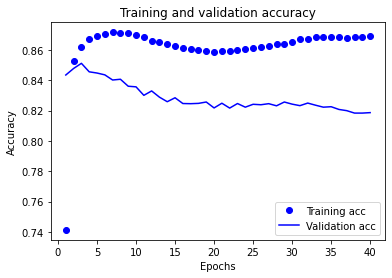

In [14]:
# Training and validation accuracy를 그려봐도 유사한 인사이트를 얻을 수 있다.
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 학습된 Embedding 레이어 분석

In [15]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [16]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/users/ho/desktop/data/wordvectors/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [43]:
# 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있다.
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['아']
vector

array([-0.054169  , -0.12585703,  0.00814735, -0.11864493,  0.18679413,
       -0.03756628, -0.17378935,  0.0169714 ,  0.03026232,  0.05350157,
        0.09699874,  0.0808576 , -0.04450553,  0.03314805, -0.00851537,
        0.04223801], dtype=float32)

In [44]:
word_vectors.similar_by_word("로맨스")

[('오타쿠', 0.8716508150100708),
 ('힝', 0.8658188581466675),
 ('서사', 0.8657470345497131),
 ('김상경', 0.8640732765197754),
 ('인연', 0.8591920137405396),
 ('배급사', 0.8539358377456665),
 ('나머지', 0.8472784757614136),
 ('이기', 0.845924437046051),
 ('중학생', 0.8402260541915894),
 ('주의', 0.8382095098495483)]

#### 학습한 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜 본다.

In [47]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [49]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 16)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [50]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=40  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40


2021-08-10 14:41:38.893733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


266/266 [==============================] - 6s 21ms/step - loss: 0.4034 - accuracy: 0.8224 - val_loss: 0.3904 - val_accuracy: 0.8325
Epoch 2/40
  1/266 [..............................] - ETA: 5s - loss: 0.3291 - accuracy: 0.8496

2021-08-10 14:41:44.493822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


266/266 [==============================] - 5s 19ms/step - loss: 0.3169 - accuracy: 0.8656 - val_loss: 0.3722 - val_accuracy: 0.8398
Epoch 3/40
266/266 [==============================] - 6s 21ms/step - loss: 0.3014 - accuracy: 0.8733 - val_loss: 0.3687 - val_accuracy: 0.8419
Epoch 4/40
266/266 [==============================] - 5s 19ms/step - loss: 0.2868 - accuracy: 0.8812 - val_loss: 0.3667 - val_accuracy: 0.8445
Epoch 5/40
266/266 [==============================] - 5s 20ms/step - loss: 0.2696 - accuracy: 0.8902 - val_loss: 0.3697 - val_accuracy: 0.8441
Epoch 6/40
266/266 [==============================] - 5s 20ms/step - loss: 0.2500 - accuracy: 0.8997 - val_loss: 0.3750 - val_accuracy: 0.8463
Epoch 7/40
266/266 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.91 - 6s 21ms/step - loss: 0.2273 - accuracy: 0.9107 - val_loss: 0.3931 - val_accuracy: 0.8447
Epoch 8/40
266/266 [==============================] - 5s 20ms/step - loss: 0.2035 - accuracy: 0.9225 - val_loss

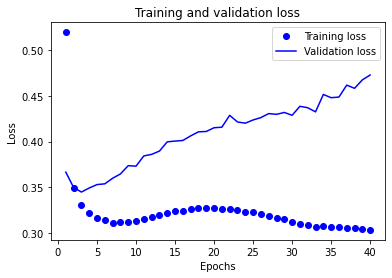

In [52]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
# 몇 epoch 까지의 트레이닝이 적절한지 최적점 추정 가능

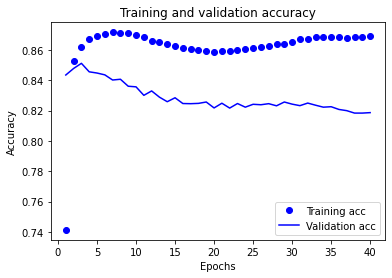

In [53]:
# Training and validation accuracy를 그려봐도 유사한 인사이트를 얻을 수 있다.
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [51]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 10s - loss: 1.4841 - accuracy: 0.8104
[1.4841431379318237, 0.810362696647644]
